### *CHARACTERISING CORTICAL DEVELOPMENT IN TERM AND PRETERM INFANTS* 

-----------------------------

*Dimitrova et al. (2021) '**Preterm birth alters the development of cortical microstructure and morphology at term-equivalent age**' biorxiv* 

-----------------------------

This Notebook:

1. loads covariates - PMA at scan & sex [csv] for term & prem infants
2. loads cortical surface data - FA, MD, ODI, fICVf, cortical thickness, curvature, sulcation, SA [csv]
3. loads random parcels surface files - total of 286 parcels (143 per hemi) [gii]
4. calculates & saves mean/std surface maps [gii] - `Fig 1`
5. creates files for PALM: correlation with age at scan PMA `Fig 1` & term-preterm group difference `Fig 2A`
6. preps data for Gaussian process regression 
7. runs Gaussian process regression 
8. calculates MAE from the hold-out term sample - `Suppl Fig 7`
9. calculates & saves Z-scores 
10. creates spatial overlap maps - `Fig 2B`
11. calculates atypicality index - `Fig 4`
12. tests for correlation b/n atypicality index & GA at birth
13. tests for correlation b/n Z-scores & GA at birth - `Fig 3`


`run from within the ./neo_cortexDev dir`

In [1]:
import pandas as pd
import numpy as np
import nibabel as nb
import GPy
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import re
from datetime import datetime

from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr, kendalltau, mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection

---------------------
***LOAD COVARIATES:***

assigns `$wd`

data live in `$wd/data`

In [4]:
# set wd:
wd = os.getcwd()
dd = wd + '/data'

# train term data:
cov = pd.read_csv('{}/train_term_cov.csv'.format(dd), header = None).values

# hold-out term & preterm infant data:
cov_test = pd.read_csv('{}/test_term_cov.csv'.format(dd), header = None).values 
cov_prem = pd.read_csv('{}/test_risk_cov.csv'.format(dd), header = None).values

print('train term-born data: {}, test term-born data: {}, preterm data: {}'.format(cov.shape[0], cov_test.shape[0], cov_prem.shape[0]))

train term-born data: 196, test term-born data: 63, preterm data: 76


------------------------
***LOAD CORTICAL FEATURES:***

data live in `$wd/data`

In [5]:
data_term_train = pd.read_csv('{}/train_term_data.csv'.format(dd)).values
data_term_test = pd.read_csv('{}/test_term_data.csv'.format(dd)).values
data_prem_test = pd.read_csv('{}/test_risk_data.csv'.format(dd)).values

# get regions and surface parcel No.
columns = pd.read_csv('{}/train_term_data.csv'.format(dd)).columns

parcel_no = np.zeros((int(len(columns)/8)))
parcel = columns[:parcel_no.shape[0]]
for i in range(0, parcel_no.shape[0]):
    parcel_no[i] = int(''.join(re.findall('_([0-9]+)', parcel[i])))
    
print('Total number of parcels: {} ({} per hemi)'.format(len(parcel_no), int(len(parcel_no)/2)))

Total number of parcels: 286 (143 per hemi)


##### LOADS PARCELS:

data live in `$wd/random_parcels`

In [6]:
# load parcel data to project results to surface:
pars_dir = wd + '/random_parcels'

hemi_left = nb.load('{}/left_cortical_parcels.shape.gii'.format(pars_dir))
hemi_right = nb.load('{}/right_cortical_parcels.shape.gii'.format(pars_dir))

parcels_left = hemi_left.darrays[0].data
parcels_right = hemi_right.darrays[0].data

-------------------------------------------------
***CREATE MEAN & STANDARD DEVIATION (STD) SURFACE MAPS:***

creates `$wd/output/surf_mean` & `$wd/output/surf_std`

visualised in `Figure 1.`

In [7]:
out_dir = wd + '/output'
mean_dir, std_dir = (out_dir + '/surf_mean'),(out_dir + '/surf_std')

for dirs in out_dir, mean_dir, std_dir:
    if not os.path.exists(dirs):
        os.mkdir(dirs)

n = len(parcel_no)
metric2parcelNo = {
    'fa': n ,
    'md': n*2,
    'odi': n*3,
    'ficvf':n*4,
    'thick':n*5,
    'curv':n*6,
    'sulc':n*7,
    'SA':n*8}

for metric in ('fa','md','odi','ficvf','thick','curv','sulc', 'SA'):
    # print(metric)
    metric_data = data_term_train[:,(metric2parcelNo.get(metric) - len(parcel_no)) : metric2parcelNo.get(metric)]
    # print(metric_data)
    
    metric_mean_dict = dict(zip(parcel_no,np.nanmean(metric_data, axis = 0)))
    metric_std_dict = dict(zip(parcel_no, np.nanstd(metric_data, axis = 0)))
    #print(metric_mean_dict) 

    metric_mean_left = []
    metric_std_left = []

    for i in parcels_left:
        metric_mean_left.append(metric_mean_dict.get(i))
        metric_std_left.append(metric_std_dict.get(i))
        
    metric_mean_left = np.array(metric_mean_left, dtype = 'float32')
    metric_std_left = np.array(metric_std_left, dtype = 'float32')
        
    metric_mean_right = []
    metric_std_right = []

    for i in parcels_right:
        metric_mean_right.append(metric_mean_dict.get(i))
        metric_std_right.append(metric_std_dict.get(i))
    
    metric_mean_right = np.array(metric_mean_right, dtype = 'float32')
    metric_std_right = np.array(metric_std_right, dtype = 'float32')
       
    for hemi in ('left', 'right'):
        if hemi == 'left':
            parcel_surf = parcels_left
            surface = hemi_left
            mean_s = metric_mean_left
            std_s = metric_std_left
            
        else:
            parcel_surf = parcels_right
            surface = hemi_right
            mean_s = metric_mean_right
            std_s = metric_std_right                       
            
        surface.remove_gifti_data_array(0)
        surface.add_gifti_data_array(nb.gifti.GiftiDataArray(np.float32(mean_s)))
        nb.save(surface, '{}/mean_{}_{}.func.gii'.format(mean_dir, metric, hemi))     
        
        surface.remove_gifti_data_array(0)
        surface.add_gifti_data_array(nb.gifti.GiftiDataArray(np.float32(std_s)))
        nb.save(surface, '{}/std_{}_{}.func.gii'.format(std_dir, metric, hemi))      

***CREATES FILES FOR PALM:***

creates `$wd/output/palm/pma` & `$wd/output/palm/group`

visualised in `Figure 1` (correlation with PMA) & `Figure 2.A` (group-wise differences)

In [8]:
palm_dir, palm_pma_dir, palm_group_dir = (out_dir + '/palm'),(out_dir + '/palm/pma'),(out_dir + '/palm/group')

for dirs in palm_dir, palm_pma_dir, palm_group_dir:
    if not os.path.exists(dirs):
        os.mkdir(dirs)
        
# PEARSON CORR WITH PMA, CONTROLLING FOR SEX: shape: [259, ?] - ALL TERM INFANTS
palm_pma_data = np.vstack((data_term_train, data_term_test))
palm_pma_cov = np.vstack((cov, cov_test))
palm_pma_cov_d = (palm_pma_cov - np.nanmean(palm_pma_cov, axis = 0)) / np.nanstd(palm_pma_cov, axis = 0)

# GROUP DIFFERENCES B/W TERM AND PRETERM INFANTS, CONTROLLING FOR PMA & SEX 
# {EXCLUDING PREM WITH CLINICAL GROSS ABNORMALITY}: shape: [334, ?]
palm_group_data = np.vstack((data_term_train, data_term_test, np.delete(data_prem_test,(40), axis = 0)))
palm_group_cov = np.vstack((cov, cov_test, np.delete(cov_prem,(40), axis = 0)))
palm_group_cov_d = (palm_group_cov - np.nanmean(palm_group_cov, axis = 0)) / np.nanstd(palm_group_cov, axis = 0)

for metric in ('fa','md','odi','ficvf','thick','curv','sulc', 'SA'):
    # print(metric)
    data_pma = palm_pma_data[:,(metric2parcelNo.get(metric) - len(parcel_no)) : metric2parcelNo.get(metric)]
    data_group = palm_group_data[:,(metric2parcelNo.get(metric) - len(parcel_no)) : metric2parcelNo.get(metric)]
    # print(metric, data_pma)
    
    pd.DataFrame(data_pma).to_csv('{}/pma_{}.csv'.format(palm_pma_dir, metric), 
                                  sep = ',', index = False, header = None)    
    pd.DataFrame(data_group).to_csv('{}/group_{}.csv'.format(palm_group_dir, metric), 
                                  sep = ',', index = False, header = None)

pd.DataFrame(palm_pma_cov_d).to_csv('{}/pma_covs_demeaned.csv'.format(palm_pma_dir), 
                                    sep = ',', index = False, header = None)
pd.DataFrame(palm_group_cov_d).to_csv('{}/group_covs_demeaned.csv'.format(palm_group_dir), 
                                    sep = ',', index = False, header = None)

------------

***PREPS DATA FOR GAUSSIAN PROCESS REGRESSION (GPR):***

In [9]:
data_term_train_mean = np.nanmean(data_term_train, axis = 0)
data_term_train_std = np.nanstd(data_term_train, axis = 0)

data_term_train_demean = (data_term_train - data_term_train_mean) / data_term_train_std
data_term_test_demean = (data_term_test - data_term_train_mean) / data_term_train_std
data_prem_test_demean = (data_prem_test - data_term_train_mean) / data_term_train_std

cov_demean = (cov - np.mean(cov, axis = 0)) / np.std(cov, axis = 0)
cov_test_demean = (cov_test - np.mean(cov, axis = 0)) / np.std(cov, axis = 0)
cov_prem_demean = (cov_prem - np.mean(cov, axis = 0)) / np.std(cov, axis = 0)

n_subj = np.shape(cov_demean)[0]
n_test = np.shape(cov_test_demean)[0] 
n_prem = np.shape(cov_prem_demean)[0] 

xdim = np.shape(data_term_train) [0]
ydim = parcel_no.shape[0]

In [10]:
test = np.vstack([cov_test_demean] * 8)
prem = np.vstack([cov_prem_demean] * 8)

test_term = []
test_prem = []

for i in range (0,8):
    test_term.append(np.repeat(i, cov_test_demean.shape[0]))
    test_prem.append(np.repeat(i, cov_prem_demean.shape[0]))
    
test_term = np.array(test_term).reshape(test.shape[0], 1)
test_indices_test = np.hstack([test, test_term]) 

test_prem = np.array(test_prem).reshape(prem.shape[0],1)
test_indices_prem = np.hstack([prem, test_prem])

noise_dict_test = {'output_index': test_indices_test[:,2:].astype(int)} 
noise_dict_prem = {'output_index': test_indices_prem[:,2:].astype(int)} 

# create empty matrices to feed in output:
pred_test = np.zeros(((n_test*8), ydim), dtype = 'float32')
var_test = np.zeros(((n_test*8), ydim), dtype = 'float32')

pred_prem = np.zeros(((n_prem*8), ydim), dtype = 'float32')
var_prem = np.zeros(((n_prem*8), ydim), dtype = 'float32')

In [11]:
# format for Multi-Output GPR:
no = len(parcel_no)

output01, output02 = data_term_train_demean[:,:no], data_term_train_demean[:,no:(no*2)]
output03, output04 = data_term_train_demean[:,(no*2):(no*3)], data_term_train_demean[:,(no*3):(no*4)]
output05, output06 = data_term_train_demean[:,(no*4):(no*5)], data_term_train_demean[:,(no*5):(no*6)]
output07, output08 = data_term_train_demean[:,(no*6):(no*7)], data_term_train_demean[:,(no*7):(no*8)]

-------------

***GPR MODEL FITTING:***


~30 min to run on one machine:

In [12]:
current_time = datetime.now().strftime("%H:%M:%S")
print("hello! Start of fitting @", current_time)

model_list = []
bmatrix = []
start = 0
finish = output01.shape[1]

for roi in range(start,finish):
    if roi % 50 == 0:
        print('parcel {} out of 300'.format(roi))
        
    # select the parcel of interest:
    train_image = [output01[:,roi:(roi+1)], output02[:,roi:(roi+1)], output03[:,roi:(roi+1)], output04[:,roi:(roi+1)],
                   output05[:,roi:(roi+1)], output06[:,roi:(roi+1)], output07[:,roi:(roi+1)], output08[:,roi:(roi+1)]]
    
    train_age = [cov_demean, cov_demean, cov_demean, cov_demean, cov_demean, cov_demean, cov_demean, cov_demean]
    
    pred_train = np.zeros(((xdim*8),1), dtype = 'float32')
    var_train = np.zeros(((xdim*8),1), dtype = 'float32')
    
    # model bits 
    k1 = GPy.kern.RBF(2, active_dims = (0,1), lengthscale = 2)  
    k2 = GPy.kern.White(2, active_dims = (0,1))
    k3 = GPy.kern.Linear(2, active_dims = (0,1))
    k_add = k1 + k2 + k3
    
    # model training to predict the hold-out samples:
    icm = GPy.util.multioutput.ICM(input_dim = 2, num_outputs = 8, kernel = k_add)    
    m = GPy.models.SparseGPCoregionalizedRegression(train_age, train_image, kernel = icm)
    m.optimize('bfgs', max_iters = 100)
    
    model_list.append(m.param_array)
    bmatrix.append(np.reshape(icm.B.B,(64,)))
        
    pred_test[:,roi:(roi+1)], var_test[:,roi:(roi+1)] = m.predict(test_indices_test, Y_metadata = noise_dict_test)
    pred_prem[:,roi:(roi+1)], var_prem[:,roi:(roi+1)] = m.predict(test_indices_prem, Y_metadata = noise_dict_prem)
    
current_time = datetime.now().strftime("%H:%M:%S")
print("Bye now! End of fitting @", current_time)    

hello! Start of fitting @ 17:34:28
parcel 0 out of 300
parcel 50 out of 300
parcel 100 out of 300
parcel 150 out of 300
parcel 200 out of 300
parcel 250 out of 300
Bye now! End of fitting @ 18:04:08


---------------
***CALCULATES MEAN ABSOLUTE ERROR (MAE) FROM THE HOLD-OUT TERM SAMPLE:***

creates `$wd/output/gpr_mae`

visualised in `Supplementary Figure 7.`

In [13]:
# format pred. to match obs. shape.
n = n_test
pred_test_T = np.hstack((pred_test[0:(n),:], pred_test[(n):(n*2),:], pred_test[(n*2):(n*3),:],
                          pred_test[(n*3):(n*4),:], pred_test[(n*4):(n*5),:], pred_test[(n*5):(n*6),:],
                          pred_test[(n*6):(n*7),:], pred_test[(n*7):(n*8),:]))

var_test_T = np.hstack((var_test[0:(n),:], var_test[(n):(n*2),:], var_test[(n*2):(n*3),:],
                          var_test[(n*3):(n*4),:], var_test[(n*4):(n*5),:], var_test[(n*5):(n*6),:],
                          var_test[(n*6):(n*7),:], var_test[(n*7):(n*8),:]))

n = n_prem
pred_prem_T = np.hstack((pred_prem[0:(n),:], pred_prem[(n):(n*2),:], pred_prem[(n*2):(n*3),:],
                          pred_prem[(n*3):(n*4),:], pred_prem[(n*4):(n*5),:], pred_prem[(n*5):(n*6),:],
                          pred_prem[(n*6):(n*7),:], pred_prem[(n*7):(n*8),:]))

var_prem_T = np.hstack((var_prem[0:(n),:], var_prem[(n):(n*2),:], var_prem[(n*2):(n*3),:],
                          var_prem[(n*3):(n*4),:], var_prem[(n*4):(n*5),:], var_prem[(n*5):(n*6),:],
                          var_prem[(n*6):(n*7),:], var_prem[(n*7):(n*8),:]))

In [14]:
mae_dir = (out_dir + '/gpr_mae')
if not os.path.exists(mae_dir):
    os.mkdir(mae_dir)

mae_test = np.zeros([pred_test_T.shape[1]])

# calculate MAE
for i in range(0, pred_test_T.shape[1]):
        mae_test[i] = np.round(mean_absolute_error(data_term_test_demean[:,i], pred_test_T[:,i]), 2)
        
# get the MAE for each metric and project:
n = len(parcel_no)

for metric in ('fa','md','odi','ficvf','thick','curv','sulc', 'SA'):
    # print(metric)
    metric_mae = mae_test[(metric2parcelNo.get(metric) - len(parcel_no)):metric2parcelNo.get(metric)]
    # print(metric_mae)      
    
    mae_left_test, mae_right_test = [] , []

    dict_mae_test = dict(np.hstack((parcel_no.reshape(-1,1), metric_mae.reshape(-1,1))))
    # print(dict_mae_test)
    
    for i in parcels_right:
        mae_right_test.append(dict_mae_test.get(i))
    mae_right_test = np.array(mae_right_test, dtype = 'float32')

    for i in parcels_left:
        mae_left_test.append(dict_mae_test.get(i))
    mae_left_test = np.array(mae_left_test, dtype = 'float32')
    
# project onto the surface:    
    for hemi in ('left', 'right'):
        # print(hemi)
        if hemi == 'left':
            parcel_surf = parcels_left
            surface = hemi_left
            mae = mae_left_test
        else:
            parcel_surf = parcels_right
            surface = hemi_right
            mae = mae_right_test
    
        surface.remove_gifti_data_array(0)
        surface.add_gifti_data_array(nb.gifti.GiftiDataArray(np.float32(mae)))
        nb.save(surface, '{}/mae_{}_{}.func.gii'.format(mae_dir, metric, hemi))

-------------

***SAVE Z-SCORES:***

creates `$wd/output/gpr_zscores`

In [15]:
zscores_dir = (out_dir + '/gpr_zscores')
if not os.path.exists(zscores_dir):
    os.mkdir(zscores_dir)

# save Z-scores for TERMs:
zscore_term = (data_term_test_demean - pred_test_T) / np.sqrt(var_test_T)
pd.DataFrame(zscore_term, columns = columns).to_csv('{}/zscores_term.csv'.format(zscores_dir), 
                                                    sep = ',', index = False)

# save Z-scores for PREMs:
zscore_prem = (data_prem_test_demean - pred_prem_T) / np.sqrt(var_prem_T)
pd.DataFrame(zscore_prem, columns = columns).to_csv('{}/zscores_prem.csv'.format(zscores_dir), 
                                                    sep = ',', index = False)

--------------------------

***SPATIAL OVERLAP MAPS:***

creates `$wd/output/spatial_overlap`

visualised in `Figure 2.B`

In [16]:
# creates dir for output:
overlap_dir, atyp_dir = (out_dir + '/spatial_overlap') , (out_dir + '/atyp_index')
 
for dirs in overlap_dir, atyp_dir:
    if not os.path.exists(dirs):
        os.mkdir(dirs)

for metric in ('fa','md','odi','ficvf','thick','curv','sulc', 'SA'):
    #print(metric)
    
    # split data:
    metric_term_z = zscore_term[:,(metric2parcelNo.get(metric) - len(parcel_no)) : metric2parcelNo.get(metric)]
    metric_prem_z = zscore_prem[:,(metric2parcelNo.get(metric) - len(parcel_no)) : metric2parcelNo.get(metric)]
    
    # calculate proportion of infants with Z>=|3.1| for every parcel:
    for group in ('term','prem'):
        
        if group == 'term':
            zdata = metric_term_z
        else:
            zdata = metric_prem_z
            
        positive = np.zeros((len(parcel_no),1))
        negative = np.zeros((len(parcel_no),1))
        
        for i in range(0, len(parcel_no)):
            # print(i, parcel_no[i])
            positive[i] = np.round(((zdata[:,i] >= 3.1).sum() / zdata.shape[0])*100, 2)
            negative[i] = np.round(((zdata[:,i] <= -3.1).sum() / zdata.shape[0])*100, 2)
        
        positive_dict = dict(np.hstack((parcel_no.reshape(-1,1), positive)))
        negative_dict = dict(np.hstack((parcel_no.reshape(-1,1), negative)))
               
        overlap_left_pos, overlap_right_pos = [] , []
        overlap_left_neg, overlap_right_neg = [] , []

        # links data to vertex No.
        for i in parcels_left:
            overlap_left_pos.append(positive_dict.get(i))
            overlap_left_neg.append(negative_dict.get(i))
            
        overlap_left_pos = np.array(overlap_left_pos, dtype = 'float32')
        overlap_left_neg = np.array(overlap_left_neg, dtype = 'float32')
        
        for i in parcels_right:
            overlap_right_pos.append(positive_dict.get(i))
            overlap_right_neg.append(negative_dict.get(i))
            
        overlap_right_pos = np.array(overlap_right_pos, dtype = 'float32')
        overlap_right_neg = np.array(overlap_right_neg, dtype = 'float32')
        
        # projects to surf:
        for hemi in ('left','right'):
            if hemi == 'left':
                parcel_surf = parcels_left
                surface = hemi_left
                overlap_positive = overlap_left_pos
                overlap_negative = overlap_left_neg
                
            else:
                parcel_surf = parcels_right
                surface = hemi_right
                overlap_positive = overlap_right_pos
                overlap_negative = overlap_right_neg
            
            # writes on surf
            surface.remove_gifti_data_array(0)
            surface.add_gifti_data_array(nb.gifti.GiftiDataArray(np.float32(overlap_positive)))
            nb.save(surface, '{}/{}_{}_pos_{}.func.gii'.format(overlap_dir, group, metric, hemi))
            
            surface.remove_gifti_data_array(0)
            surface.add_gifti_data_array(nb.gifti.GiftiDataArray(np.float32(overlap_negative)))
            nb.save(surface, '{}/{}_{}_neg_{}.func.gii'.format(overlap_dir, group, metric, hemi))

-----------------------------------

***WHOLE CORTEX ATYPICALITY INDEX (PER INFANT):***

creates `$wd/output/atyp_index`

In [17]:
# long format:
term_atyp_pos, term_atyp_neg = [],[] 
prem_atyp_pos, prem_atyp_neg = [],[]
metric_col_term, metric_col_prem = [],[]
group_col_term, group_col_prem = [],[]

for metric in ('fa','md','odi','ficvf','thick','curv','sulc', 'SA'):
    # print(metric)
    
    # SELECT DATA FOR MEASURE:
    atyp_term_data = zscore_term[:,(metric2parcelNo.get(metric) - len(parcel_no)) : metric2parcelNo.get(metric)]
    atyp_prem_data = zscore_prem[:,(metric2parcelNo.get(metric) - len(parcel_no)) : metric2parcelNo.get(metric)]
    # print(atyp_term_data.shape, atyp_prem_data.shape)
    
    # CALCULATE ATYPICALITY FOR MEASURE PER GROUP:
    for i in range(0, n_test):
        #print(i)
        term_atyp_pos.append(np.round(((atyp_term_data[i,:] >= 3.1).sum() / len(parcel_no))*100, 2))
        term_atyp_neg.append(np.round(((atyp_term_data[i,:] <= -3.1).sum() / len(parcel_no))*100, 2))
        metric_col_term.append(metric)
        group_col_term.append('term')
        
    for i in range(0, n_prem):
        #print(i)
        prem_atyp_pos.append(np.round(((atyp_prem_data[i,:] >= 3.1).sum() / len(parcel_no))*100, 2))
        prem_atyp_neg.append(np.round(((atyp_prem_data[i,:] <= -3.1).sum() / len(parcel_no))*100, 2))
        metric_col_prem.append(metric)
        group_col_prem.append('prem')
    
# CREATING DF:
atypicality_log = pd.DataFrame(
        {'group': (group_col_term + group_col_prem),
        'metric': (metric_col_term + metric_col_prem),
        'pos_atyp': (term_atyp_pos + prem_atyp_pos),
        'neg_atyp': (term_atyp_neg + prem_atyp_neg)
        })

# SAVE FILE:
atypicality_log.to_csv('{}/atypicality_index.csv'.format(atyp_dir), sep = ',', index = False)

---------------
***PLOT ATYPICALITY INDICES:***

plots go to `$wd/output/atyp_index`

visualised in `Figure 4.` 

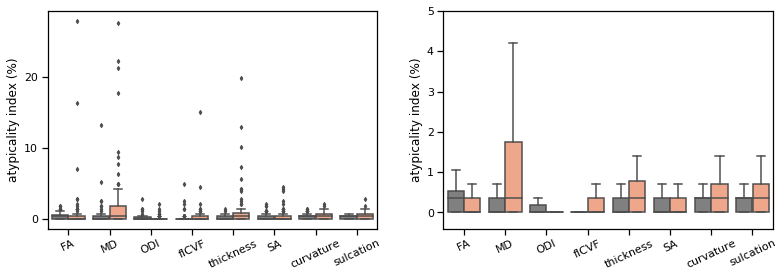

In [18]:
sns.set_context('notebook')
plt.figure(figsize=(13,4))

# FIRTS PLOT: WITH OUTLIERS
plt.subplot(1,2,1)
sns.boxplot(x = "metric", y = "pos_atyp", hue = "group", 
            order = ['fa','md','odi','ficvf','thick','SA','curv','sulc'],
            data = atypicality_log, linewidth = 1.5, width = 0.8, 
            palette = ['grey','lightsalmon'], fliersize = 3)
plt.xlabel('')
plt.ylabel('atypicality index (%)')
plt.title('')
plt.xticks(rotation = 25)
plt.xticks(np.arange(8), ('FA','MD','ODI','fICVF','thickness','SA','curvature','sulcation',))
plt.locator_params(axis = 'y', nbins = 6)
plt.legend([],[], frameon=False)

# SECOND PLOT: WITHOUT OUTLIERS:
plt.subplot(1,2,2)
sns.boxplot(x = "metric", y = "pos_atyp", hue = "group", 
            order = ['fa','md','odi','ficvf','thick','SA','curv','sulc'],
            data = atypicality_log, linewidth = 1.5, width = 0.8, 
            palette = ['grey','lightsalmon'], fliersize = 3, showfliers = False)

plt.ylim(-0.4,5)
plt.xlabel('')
plt.ylabel('atypicality index (%)')
plt.title('')
plt.xticks(rotation = 25)
plt.xticks(np.arange(8), ('FA','MD','ODI','fICVF','thickness','SA','curvature','sulcation',))
plt.locator_params(axis = 'y', nbins = 6)
plt.legend([],[], frameon = False)

# SAVE PLOT:
plt.savefig('{}/pos_atyp.png'.format(atyp_dir), bbox_inches = 'tight',dpi = 200)

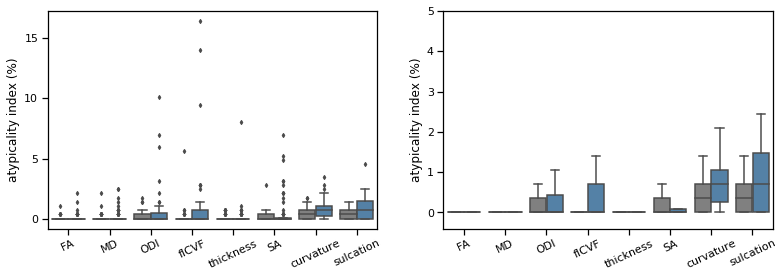

In [19]:
plt.figure(figsize=(13,4))

# FIRTS PLOT: WITH OUTLIERS
plt.subplot(1,2,1)
sns.boxplot(x = "metric", y = "neg_atyp", hue = "group", 
            order = ['fa','md','odi','ficvf','thick','SA','curv','sulc'],
            data = atypicality_log, linewidth = 1.5, width = 0.8, 
            palette = ['grey','steelblue'], fliersize = 3) 

#plt.ylim(-0.4,4) # frame for showfliers = False
plt.xlabel('')
plt.ylabel('atypicality index (%)')
plt.title('')
plt.xticks(rotation = 25)
plt.xticks(np.arange(8), ('FA','MD','ODI','fICVF','thickness','SA','curvature','sulcation'))
plt.locator_params(axis = 'y', nbins = 6)
plt.legend([],[], frameon = False)

# SECOND PLOT: WITHOUT OUTLIERS:
plt.subplot(1,2,2)
sns.boxplot(x = "metric", y = "neg_atyp", hue = "group", 
            order = ['fa','md','odi','ficvf','thick','SA','curv','sulc'],
            data = atypicality_log, linewidth = 1.5, width = 0.8, 
            palette = ['grey','steelblue'], fliersize = 3, showfliers = False)

plt.ylim(-0.4,5)
plt.xlabel('')
plt.ylabel('atypicality index (%)')
plt.title('')
plt.xticks(rotation = 25)
plt.xticks(np.arange(8), ('FA','MD','ODI','fICVF','thickness','SA','curvature','sulcation'))
plt.locator_params(axis = 'y', nbins = 6)
plt.legend([],[], frameon = False)

# SAVE PLOT:
plt.savefig('{}/neg_atyp.png'.format(atyp_dir), bbox_inches = 'tight',dpi = 200)

------------------
***GROUP DIFFERENCES IN ATYPICALITY INDEX:***


*MANN WHITNEY + FDR CORRECTIONS*

In [20]:
from scipy.stats import kendalltau, mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection

for valen in ('pos_atyp', 'neg_atyp'):
    print(valen)
    print()
    pvals_U = []
    
    for metric in ('fa','md','odi','ficvf','thick','curv','sulc', 'SA'):
        
        term_m = atypicality_log[(atypicality_log['group'] == 'term') & 
                            (atypicality_log['metric'] == metric)][valen].values
        prem_m = atypicality_log[(atypicality_log['group'] == 'prem') & 
                            (atypicality_log['metric'] == metric)][valen].values  

        u, p = mannwhitneyu(term_m, prem_m)
        pvals_U.append(p)
        print(metric, 'MannW U: ', np.round(u, 2), np.round(p, 3))
    
    _, pvals_U_fdr = fdrcorrection(pvals_U)
    print('FDR:', np.round(pvals_U_fdr, 3))
    print()

pos_atyp

fa MannW U:  2152.0 0.133
md MannW U:  1558.0 0.0
odi MannW U:  2322.0 0.342
ficvf MannW U:  2213.5 0.156
thick MannW U:  1631.5 0.0
curv MannW U:  2256.5 0.27
sulc MannW U:  1790.5 0.003
SA MannW U:  2068.5 0.058
FDR: [0.208 0.001 0.342 0.208 0.001 0.308 0.009 0.116]

neg_atyp

fa MannW U:  2271.5 0.182
md MannW U:  2209.0 0.129
odi MannW U:  1807.0 0.002
ficvf MannW U:  1645.5 0.0
thick MannW U:  2385.5 0.479
curv MannW U:  1828.5 0.007
sulc MannW U:  1708.0 0.002
SA MannW U:  2353.5 0.413
FDR: [0.243 0.206 0.006 0.    0.479 0.014 0.006 0.472]



-------------------
***CORRELATION BETWEEN ATYPICALITY INDEX & GA AT BIRTH:***


*KENDALL TAU (+ SPEARMAN RHO) + FDR CORRECTION*

In [21]:
# LOAD GA DATA:
ga_term = pd.read_csv('{}/test_term_ga.csv'.format(dd), header = None).values
ga_prem = pd.read_csv('{}/test_risk_ga.csv'.format(dd), header = None).values
ga = np.vstack((ga_term, ga_prem))

for valen in ('pos_atyp', 'neg_atyp'):
    print(valen)
    print()
    pvals_ga = []
    
    for metric in ('fa','md','odi','ficvf','thick','curv','sulc', 'SA'):

# COMBINED SAMPLE TERM + PREMS:
            pos_ = atypicality_log[(atypicality_log['metric'] == metric)][valen].values

# INDIVIDUAL GROUPS:
#            term_pos_ = atypicality_log[(atypicality_log['group'] == 'term') & 
#                            (atypicality_log['metric'] == metric)][valen].values
#            prem_pos_ = atypicality_log[(atypicality_log['group'] == 'prem') & 
#                            (atypicality_log['metric'] == metric)][valen].values  
    
            tau, pval = kendalltau(pos_, ga, nan_policy = 'omit')
            rho, pval02 = spearmanr(pos_, ga, nan_policy = 'omit')
            print(metric, 'tau:', np.round(tau, 2), np.round(pval, 4), 'rho:', np.round(rho, 2), np.round(pval02, 4))
            pvals_ga.append(pval)
    
    _, pvals_ga_fdr = fdrcorrection(pvals_ga)
    print('FDR:', np.round(pvals_ga_fdr, 3))
    print()

pos_atyp

fa tau: 0.08 0.2292 rho: 0.1 0.2333
md tau: -0.25 0.0001 rho: -0.32 0.0001
odi tau: 0.02 0.8176 rho: 0.02 0.8373
ficvf tau: -0.11 0.1079 rho: -0.13 0.1185
thick tau: -0.2 0.0023 rho: -0.26 0.0018
curv tau: -0.02 0.7152 rho: -0.03 0.6892
sulc tau: -0.18 0.0055 rho: -0.24 0.004
SA tau: -0.02 0.7042 rho: -0.04 0.6547
FDR: [0.367 0.001 0.818 0.216 0.009 0.817 0.015 0.817]

neg_atyp

fa tau: -0.09 0.1958 rho: -0.11 0.1987
md tau: -0.06 0.3713 rho: -0.08 0.3681
odi tau: -0.16 0.0184 rho: -0.21 0.0152
ficvf tau: -0.26 0.0001 rho: -0.33 0.0001
thick tau: -0.02 0.8029 rho: -0.02 0.8001
curv tau: -0.23 0.0002 rho: -0.31 0.0002
sulc tau: -0.23 0.0002 rho: -0.31 0.0002
SA tau: -0.06 0.4137 rho: -0.08 0.3686
FDR: [0.313 0.473 0.037 0.001 0.803 0.001 0.001 0.473]



-----------------------------------------------------------------------
***CORRELATION BETWEEN Z-SCORES & GA AT BIRTH:***

*PREP FORMAT FOR PALM (Z-SCORES)*

creates `$wd/output/palm/ga_Zscore`

visualised in `Figure 3.`

In [22]:
palm_ga_dir = (out_dir + '/palm/ga_Zscore')

if not os.path.exists(palm_ga_dir):
    os.mkdir(palm_ga_dir)
    
# GA FOR PREMS & TERMS:
palm_prem_ga_d = (ga_prem - np.nanmean(ga_prem)) / np.nanstd(ga_prem)
palm_term_ga_d = (ga_term - np.nanmean(ga_term)) / np.nanstd(ga_term)
palm_ga_comb_d = (ga - np.nanmean(ga)) / np.nanstd(ga)

zscore_comb = np.vstack((zscore_term, zscore_prem))

# FOR COMBINED SAMPLE:
for metric in ('fa','md','odi','ficvf','thick','curv','sulc', 'SA'):
    data_ga_z = zscore_prem[:,(metric2parcelNo.get(metric) - len(parcel_no)) : metric2parcelNo.get(metric)]
    data_ga_z_term = zscore_term[:,(metric2parcelNo.get(metric) - len(parcel_no)) : metric2parcelNo.get(metric)]
    data_ga_z_comb = zscore_comb[:,(metric2parcelNo.get(metric) - len(parcel_no)) : metric2parcelNo.get(metric)]
        
    pd.DataFrame(data_ga_z).to_csv('{}/ga_zscore_{}_76.csv'.format(palm_ga_dir, metric), 
                                  sep = ',', index = False, header = None) 
    pd.DataFrame(data_ga_z_term).to_csv('{}/ga_zscore_term_{}_63.csv'.format(palm_ga_dir, metric), 
                                  sep = ',', index = False, header = None)
    pd.DataFrame(data_ga_z_comb).to_csv('{}/ga_zscore_comb_{}_139.csv'.format(palm_ga_dir, metric), 
                                  sep = ',', index = False, header = None) 
    
pd.DataFrame(palm_prem_ga_d).to_csv('{}/ga_prem_76.csv'.format(palm_ga_dir),
                                   sep = ',', index = False, header = None)
pd.DataFrame(palm_term_ga_d).to_csv('{}/ga_term_63.csv'.format(palm_ga_dir),
                                   sep = ',', index = False, header = None)
pd.DataFrame(palm_ga_comb_d).to_csv('{}/ga_comb_139.csv'.format(palm_ga_dir),
                                   sep = ',', index = False, header = None)